# Catnip

In [1]:
# Dependencies and configuration
import os
import importlib
from src.config import settings

os.makedirs(settings.panels_dir, exist_ok=True)
os.makedirs(settings.crops_dir, exist_ok=True)
os.makedirs(settings.izutsumi_dir, exist_ok=True)
os.makedirs(settings.output_dir, exist_ok=True)

seed_paths = [str(p) for p in sorted(settings.izutsumi_dir.glob("*.jpg"))] # Seeds
neg_paths = [str(p) for p in sorted(settings.anti_izutsumi_dir.glob("*.jpg"))]

## Pre-processing

### Panel extraction

In [ ]:
from modules.coreMPE.src.adenzu_panel.image_processing import panel

_ = panel.extract_panels_for_images_in_folder_recursive(
    input_dir=str(settings.pages_dir),
    output_dir=str(settings.panels_dir),
    split_joint_panels=False,   # maps to --split-joint-panels
    fallback=True              # maps to --fallback
)

### Head crops

In [ ]:
# Extract head crops (YOLOv8_animeface)
from src.headExtraction import anime_extraction_recursive

valid_exts = {".jpg", ".jpeg", ".png"}
panel_paths = sorted(
    [p for p in settings.panels_dir.iterdir() if p.suffix.lower() in valid_exts]
)
num_crops = anime_extraction_recursive()

print(f"Extracted {num_crops} faces")

## Catnip core

### Model building

In [2]:
import src.embeddingModel
importlib.reload(src.embeddingModel)

from src.embeddingModel import compute_embeddings, build_model, load_embeddings

#### New model

In [3]:
# Build fresh model without loading weights (for new embedding computation)
embed_model = build_model(settings.img_size, settings.crops_dir, load_weights=False)
compute_embeddings(embed_model, settings.crops_dir, settings.img_size)

Found 20654 crops under data/crops


Embedding batches: 100%|██████████| 323/323 [00:59<00:00,  5.42it/s]

Successfully embedded 20654 crops
Generated embeddings of shape (20654, 1024)
Saved embeddings to data/embeddings.npy
Saved crop paths to data/crop_paths.json
Saved model weights to data/model.weights.h5


(array([[-1.12804046e-05, -1.09042003e-05, -9.65755953e-06, ...,
         -2.61921991e-06,  1.31049728e-05,  2.84634689e-06],
        [-1.37230472e-05, -1.15928651e-05, -1.05225045e-05, ...,
         -2.06807658e-06,  1.54612317e-05,  4.01518446e-06],
        [-1.50987180e-05, -1.18637290e-05, -1.08380209e-05, ...,
         -1.73713488e-06,  1.83459269e-05,  4.57122451e-06],
        ...,
        [-1.59620377e-05, -1.36245535e-05, -1.34319425e-05, ...,
          2.94844853e-07,  1.81454216e-05,  5.53914015e-06],
        [-1.68999595e-05, -1.58478288e-05, -1.36285271e-05, ...,
         -4.91228775e-07,  1.92767347e-05,  4.79690789e-06],
        [-1.42048721e-05, -1.27526937e-05, -1.27358735e-05, ...,
         -9.60182888e-07,  1.65547572e-05,  4.82908217e-06]],
       shape=(20654, 1024), dtype=float32),
 ['data/crops/v12/014_6_face_0.jpg',
  'data/crops/v12/074_0_face_1.jpg',
  'data/crops/v12/084_4_face_0.jpg',
  'data/crops/v12/201_1_face_0.jpg',
  'data/crops/v12/121_5_face_0.jpg',
 

#### Previous model

In [ ]:
# Build embedding model (loads saved weights if available)
embed_model = build_model(settings.img_size, settings.crops_dir, load_weights=True)
embs, crop_paths = load_embeddings(settings.embed_path, settings.crop_path)

## Outputting

In [4]:
import src.query
import src.output
importlib.reload(src.query) 
importlib.reload(src.output)

from src.query import izutsumi_query, izutsuminess_rank
from src.output import save_similar_results, char_nearest_neighbor

import matplotlib.pyplot as plt

In [5]:
crop, index, score, thre = izutsumi_query(settings.embed_path,
                                        settings.crop_path,
                                        settings.img_size, 
                                        embed_model, 
                                        seed_paths,
                                        neg_paths,
                                        similarity_threshold=-1,
                                        alpha=0.5,
                                        mode='max')

Found 20654 crops above similarity threshold -1


In [8]:
index = izutsuminess_rank(settings.embed_path, settings.crop_path, embed_model, seed_paths, neg_paths)

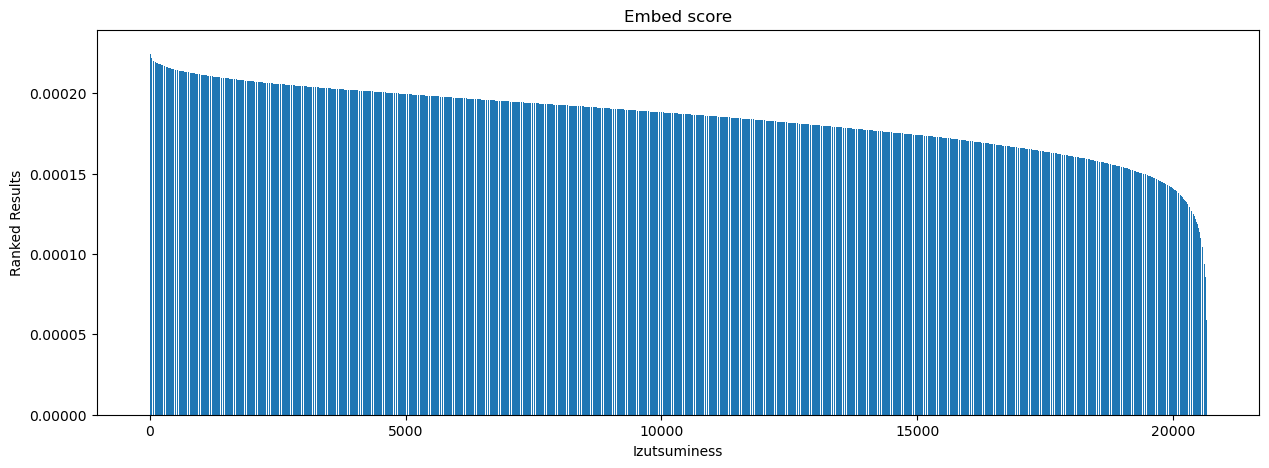

In [9]:
plt.figure(figsize=(15, 5))
plt.bar(range(len(index)), score)
plt.xlabel("Izutsuminess")
plt.ylabel("Ranked Results")
plt.title("Embed score")
plt.show()

Showing top 120 results out of 20654 matches


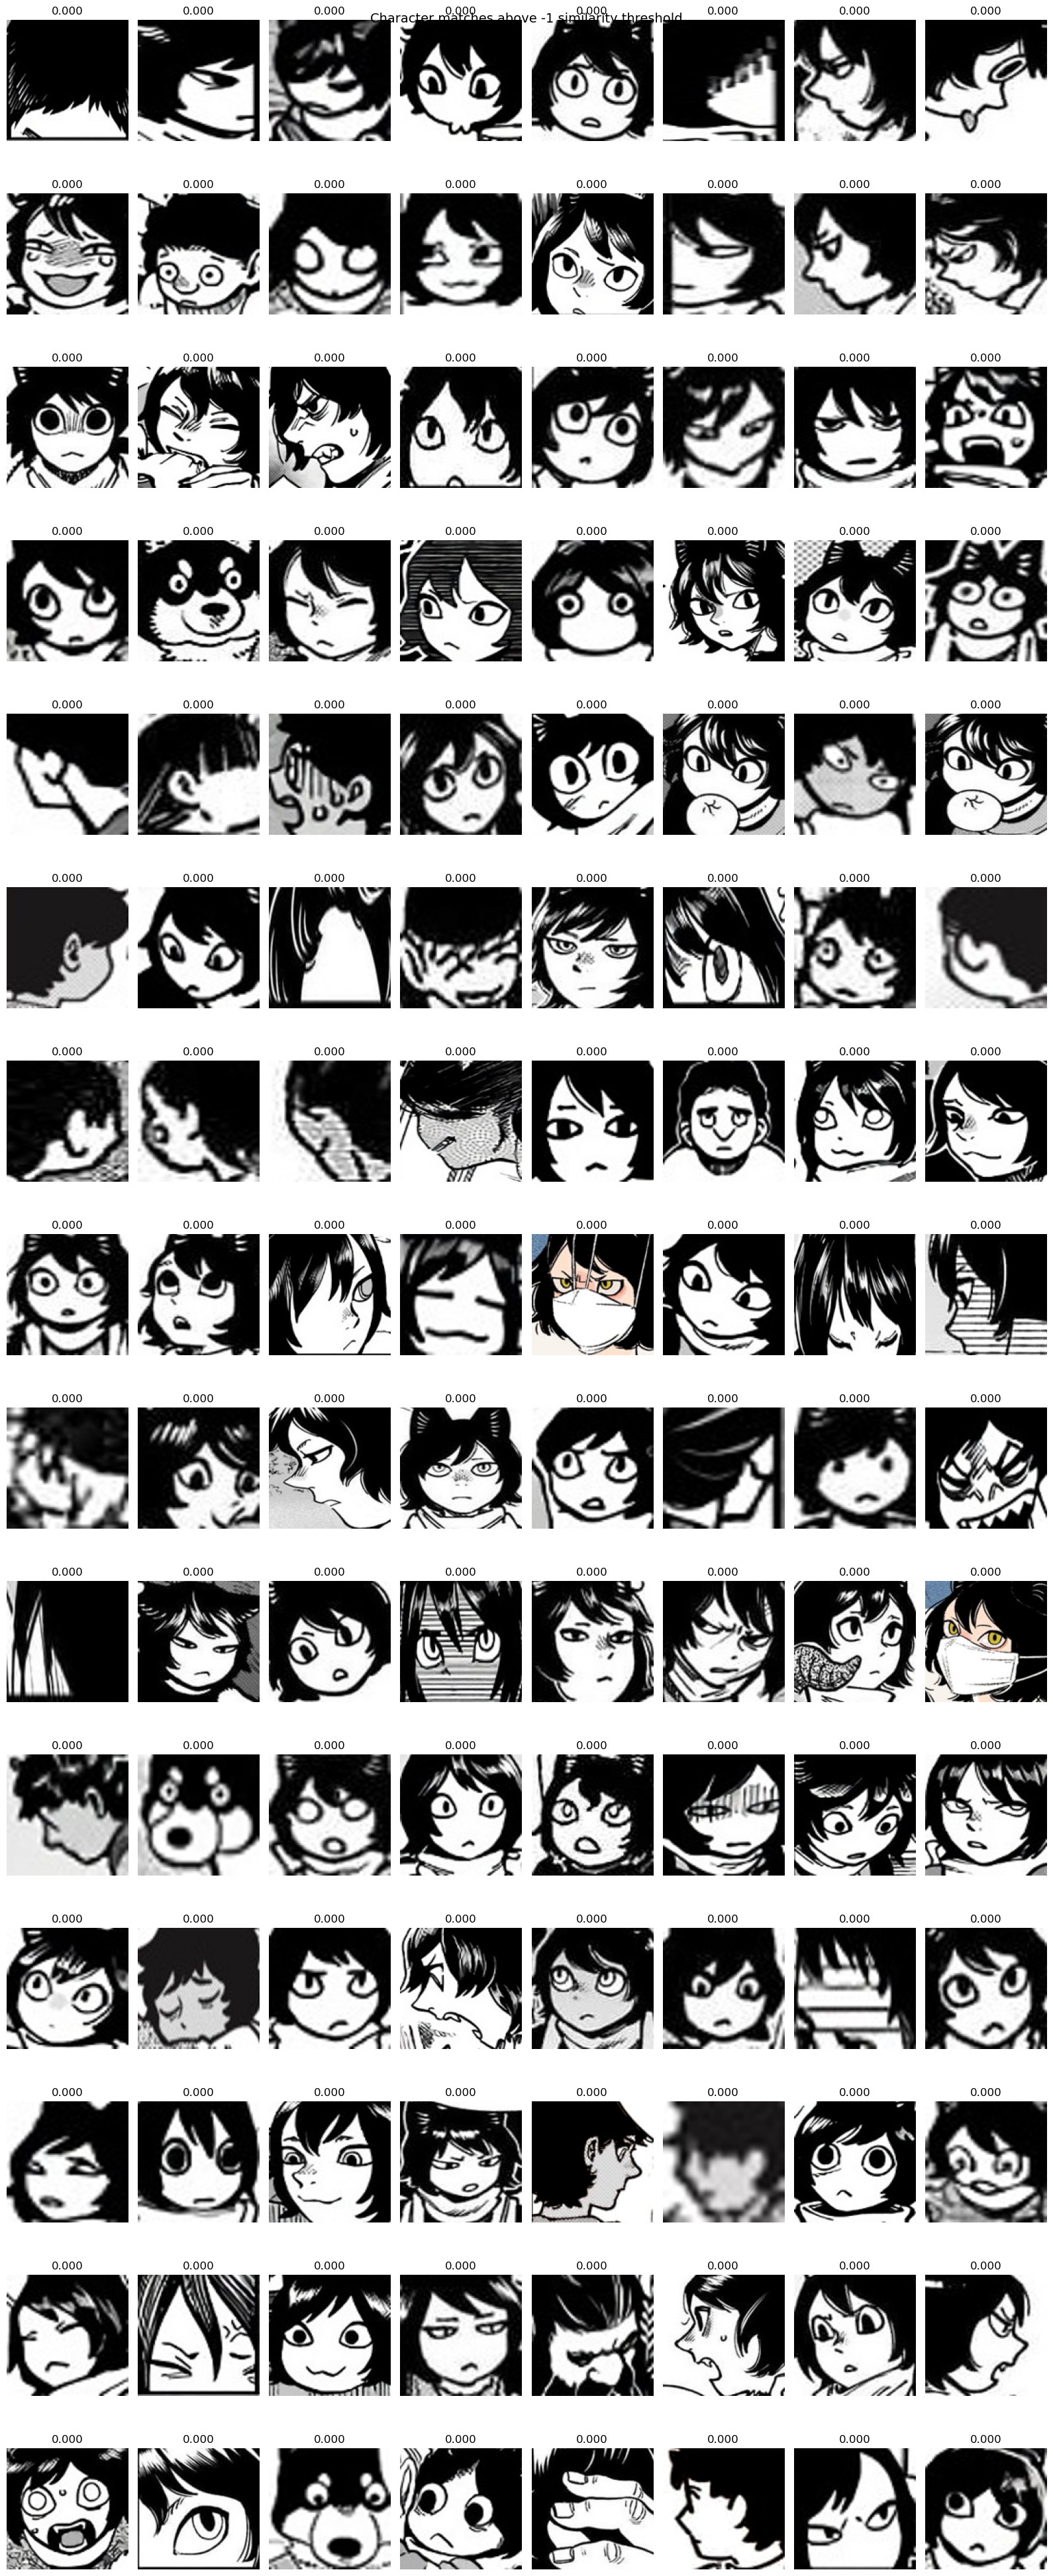

In [10]:
cutoff = 0

results = char_nearest_neighbor(crop, index[cutoff:], score[cutoff:], thre)

In [ ]:
save_similar_results(crop, index, settings.output_dir, score)